In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import matplotlib.dates as mdates
from sklearn.preprocessing import StandardScaler

import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

plt.style.use("seaborn-v0_8")
sns.set_palette("husl")
print(f"Divice available: {'MPS' if torch.backends.mps.is_available() else 'CPU'}")


Divice available: MPS


In [20]:
df = pd.read_csv("./data/VIC.csv")
print(f"Dataset shape:{df.shape}")
print(f"Data range: {df['time'].min()} to {df['time'].max()}")

df["time"] = pd.to_datetime(df["time"])
df = df.sort_values("time").reset_index(drop=True)

print("\nFirst few rows:")
display(df.head())

print("\nData types:")
print(df.dtypes)

print("\nBasic statistics:")
display(df.describe())


Dataset shape:(1500, 7)
Data range: 2020-08-03 to 2025-08-01

First few rows:


,time,open,high,low,close,volume,symbol
0,2020-08-03,77.33,78.31,75.56,77.87,164310,VIC
1,2020-08-04,78.84,78.84,77.69,78.22,229230,VIC
2,2020-08-05,78.22,78.67,75.38,77.33,434490,VIC
3,2020-08-06,78.22,78.40,77.42,77.78,332340,VIC
4,2020-08-07,77.87,78.40,77.60,77.78,182500,VIC



Data types:
time      datetime64[ns]
open             float64
high             float64
low              float64
close            float64
volume             int64
symbol            object
dtype: object

Basic statistics:


,time,open,high,low,close,volume
count,1500,1500.000000,1500.000000,1500.000000,1500.000000,1.500000e+03
mean,2023-05-31 20:30:43.200000,66.962047,67.855153,65.962507,66.945673,3.237043e+06
min,2020-08-03 00:00:00,39.700000,40.100000,38.700000,39.900000,9.045000e+04
25%,2022-01-25 18:00:00,43.350000,43.900000,42.887500,43.337500,1.416521e+06
50%,2023-07-31 12:00:00,59.700000,60.800000,58.200000,59.700000,2.085500e+06
75%,2024-10-29 06:00:00,91.560000,92.800000,89.347500,91.417500,3.419875e+06
max,2025-08-01 00:00:00,128.000000,129.690000,127.110000,128.000000,2.823433e+07
std,NaN,23.807897,24.240006,23.308936,23.787486,3.482834e+06


In [21]:
# Tạo essesstial features
print("\nCreating essential features...")
df["daily_return"] = df["close"].pct_change()
df["close_log"] = np.log(df["close"])
print(" - daily_return: phần trăm thay đổi hàng ngày")
print(" - close_log: log của giá đóng cửa")

missing_info = df.isnull().sum()
print(f"\nMissing values:")
display(missing_info)

# Xử lý missing values



Creating essential features...
 - daily_return: phần trăm thay đổi hàng ngày
 - close_log: log của giá đóng cửa

Missing values:


time            0
open            0
high            0
low             0
close           0
volume          0
symbol          0
daily_return    1
close_log       0
dtype: int64

In [22]:
# Missing values handling
print("\nHandling missing values...")
if df["daily_return"].isnull().sum() > 0:
    df["daily_return"].fillna(0, inplace=True)

missing_after = df.isnull().sum()
print(f"\nMissing values after handling:")
display(missing_after)



Handling missing values...

Missing values after handling:


time            0
open            0
high            0
low             0
close           0
volume          0
symbol          0
daily_return    0
close_log       0
dtype: int64

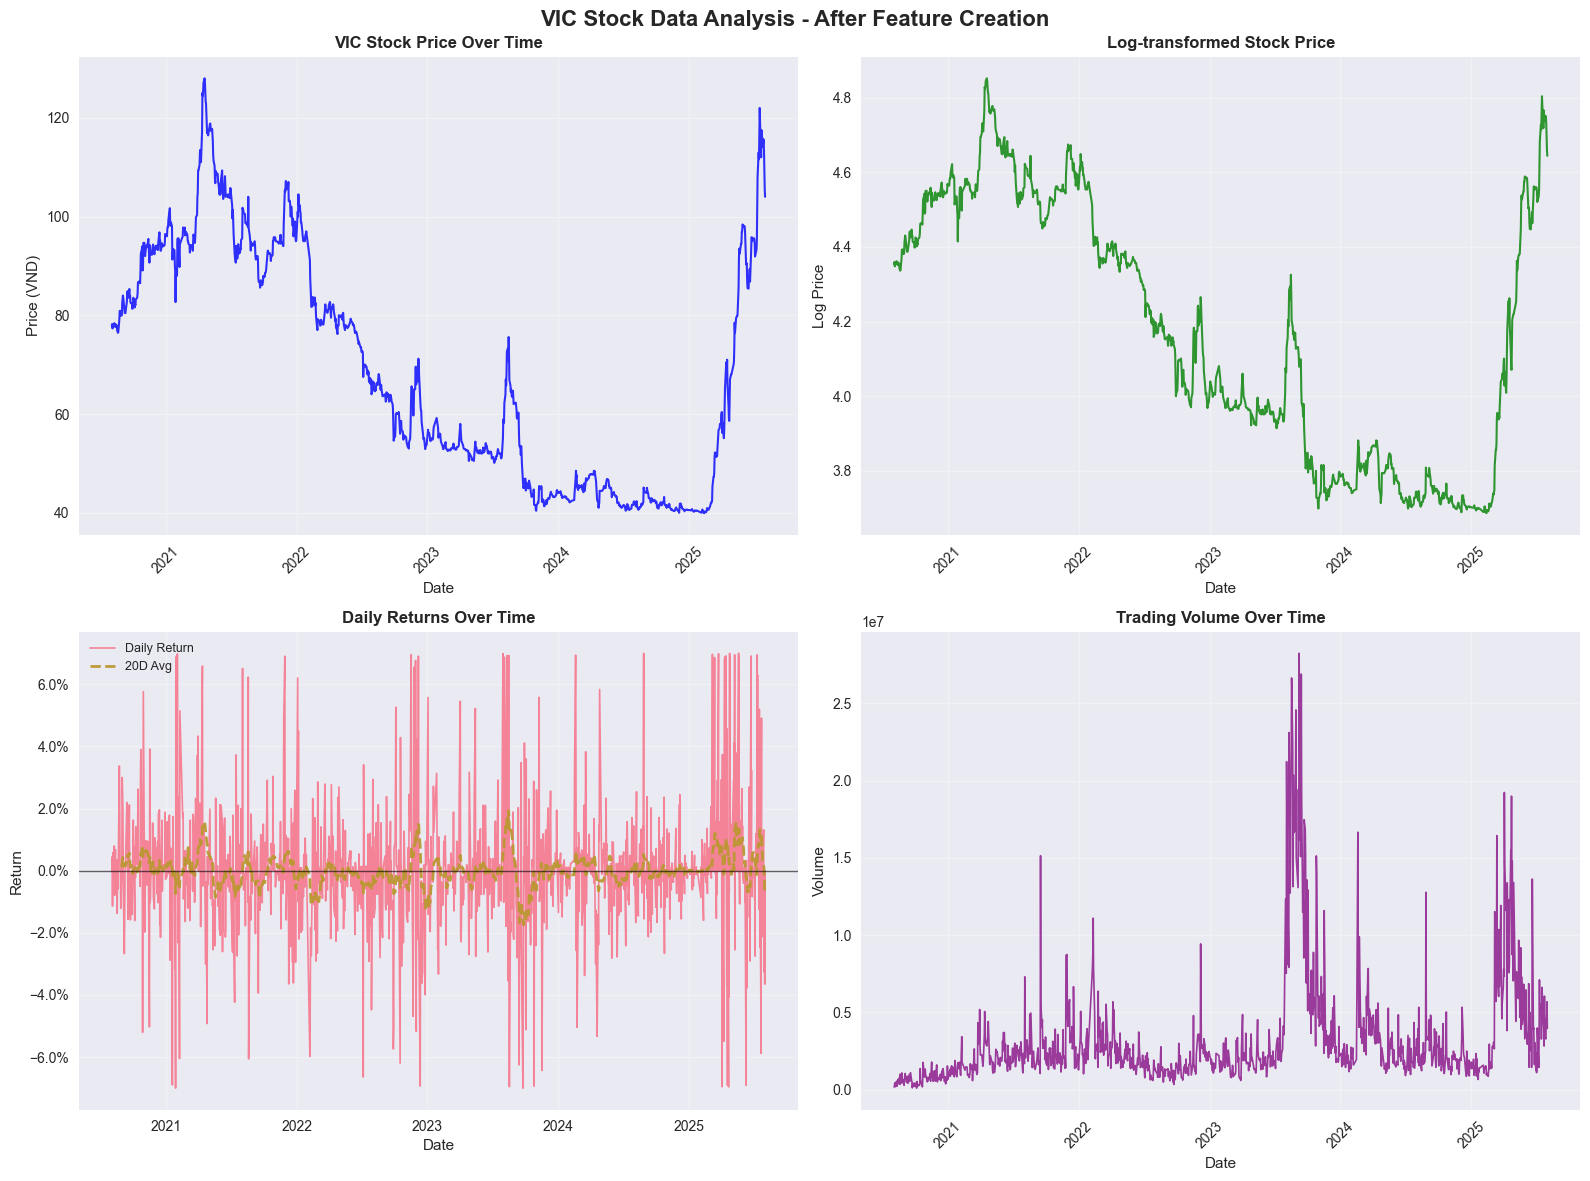

In [23]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle(
    "VIC Stock Data Analysis - After Feature Creation", fontsize=16, fontweight="bold"
)

# 1) Stock Price Over Time
axes[0, 0].plot(df["time"], df["close"], linewidth=1.5, color="blue", alpha=0.8)
axes[0, 0].set_title("VIC Stock Price Over Time", fontsize=12, fontweight="bold")
axes[0, 0].set_xlabel("Date")
axes[0, 0].set_ylabel("Price (VND)")
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].tick_params(axis="x", rotation=45)

# 2) Log-transformed Price
axes[0, 1].plot(df["time"], df["close_log"], linewidth=1.5, color="green", alpha=0.8)
axes[0, 1].set_title("Log-transformed Stock Price", fontsize=12, fontweight="bold")
axes[0, 1].set_xlabel("Date")
axes[0, 1].set_ylabel("Log Price")
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].tick_params(axis="x", rotation=45)

# 3) Daily Returns Over Time (time-series thay histogram)
ret_ts = df[["time", "daily_return"]].dropna().copy()
ret_ts["ret_ma20"] = ret_ts["daily_return"].rolling(20).mean()

axes[1, 0].plot(
    ret_ts["time"],
    ret_ts["daily_return"],
    linewidth=1.2,
    alpha=0.85,
    label="Daily Return",
)
axes[1, 0].plot(
    ret_ts["time"],
    ret_ts["ret_ma20"],
    linewidth=2.0,
    linestyle="--",
    alpha=0.95,
    label="20D Avg",
)
axes[1, 0].axhline(0, color="black", linewidth=1, alpha=0.6)

axes[1, 0].set_title("Daily Returns Over Time", fontsize=12, fontweight="bold")
axes[1, 0].set_xlabel("Date")
axes[1, 0].set_ylabel("Return")
axes[1, 0].yaxis.set_major_formatter(PercentFormatter(1.0))  # hiển thị %
axes[1, 0].xaxis.set_major_locator(mdates.AutoDateLocator())
axes[1, 0].xaxis.set_major_formatter(
    mdates.ConciseDateFormatter(mdates.AutoDateLocator())
)
axes[1, 0].tick_params(axis="x", rotation=0)
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].legend(fontsize=9)

# 4) Volume Over Time
axes[1, 1].plot(df["time"], df["volume"], linewidth=1.2, color="purple", alpha=0.75)
axes[1, 1].set_title("Trading Volume Over Time", fontsize=12, fontweight="bold")
axes[1, 1].set_xlabel("Date")
axes[1, 1].set_ylabel("Volume")
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

In [24]:
class UnivariateTimeSeriesDataset(Dataset):
    # Dự đoán cho 5 ngày mới
    def __init__(self, data, seq_len, pred_len=5, target_col="close", normalize=False):
        self.data = data.dropna().reset_index(drop=True)
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.target_col = target_col
        self.normalize = normalize

        self.series = self.data[target_col].values

        if normalize:
            self.mean = np.mean(self.series)
            self.std = np.std(self.series)

    def __len__(self):
        return len(self.series) - self.seq_len - self.pred_len + 1

    def __getitem__(self, index):
        x = self.series[index : index + self.seq_len].copy()
        y = self.series[
            index + self.seq_len : index + self.seq_len + self.pred_len
        ].copy()

        if self.normalize:
            x = (x - self.mean) / self.std
            y = (y - self.mean) / self.std

        return torch.FloatTensor(x), torch.FloatTensor(y)

    def denormalize(self, normalized_values):
        if not self.normalize:
            return normalized_values
        return normalized_values * self.std + self.mean


def create_univariate_datasets(df, seq_lengths, pred_len=5, target_col="close"):
    datasets = {}

    for seq_len in seq_lengths:
        dataset = UnivariateTimeSeriesDataset(
            data=df,
            seq_len=seq_len,
            pred_len=pred_len,
            target_col=target_col,
            normalize=False,
        )
        datasets[f"{seq_len}d"] = dataset

    return datasets


# Create datasets cho bài toán dự báo 5 ngày với các độ dài cửa sổ khác nhau
seq_lengths = [5, 30, 120, 480]
pred_len = 5  # dự báo cho 5 ngày tiếp theo

# Create datasets using log prices for better stability
datasets = create_univariate_datasets(df, seq_lengths, pred_len, "close_log")

print(f"Create datasets cho dự báo 5 ngat2 tới với input lengths: {seq_lengths}")
for name, dataset in datasets.items():
    print(f"- {name}: {len(dataset)} samples")

Create datasets cho dự báo 5 ngat2 tới với input lengths: [5, 30, 120, 480]
- 5d: 1491 samples
- 30d: 1466 samples
- 120d: 1376 samples
- 480d: 1016 samples


In [25]:
# Create train/val/test splits for univariate datasets
def create_time_based_splits(dataset, train_ratio=0.7, val_ratio=0.15):
    total_len = len(dataset)
    train_len = int(total_len * train_ratio)
    val_len = int(total_len * val_ratio)

    train_indices = list(range(0, train_len))
    val_indices = list(range(train_len, train_len + val_len))
    test_indices = list(range(train_len + val_len, total_len))

    train_dataset = torch.utils.data.Subset(dataset, train_indices)
    val_dataset = torch.utils.data.Subset(dataset, val_indices)
    test_dataset = torch.utils.data.Subset(dataset, test_indices)

    return train_dataset, val_dataset, test_dataset


data_splits = {}
print("Creating time-based data splits:")
print("- Train: 70%, Validation: 15%, Test: 15%")
print("- Temporal order preserved (no shuffling)")

for seq_name, dataset in datasets.items():
    train, val, test = create_time_based_splits(dataset)
    data_splits[seq_name] = {"train": train, "val": val, "test": test}

    if len(train) > 0 and len(val) > 0:
        last_train_idx = (
            train.indices[-1] if hasattr(train, "indices") else len(train) - 1
        )
        first_val_idx = val.indices[0] if hasattr(val, "indices") else 0

print(f"\nTotal datasets with splits: {len(data_splits)}")

# Verify split integrity
print(f"\n=== SPLIT VERIFICATION ===")
for seq_name, splits in data_splits.items():
    total_samples = len(splits["train"]) + len(splits["val"]) + len(splits["test"])
    original_samples = len(datasets[seq_name])

    print(
        f"{seq_name}: {total_samples}/{original_samples} samples ✓"
        if total_samples == original_samples
        else f"{seq_name}: ERROR - {total_samples}/{original_samples}"
    )

print("\nData splits created successfully!")

Creating time-based data splits:
- Train: 70%, Validation: 15%, Test: 15%
- Temporal order preserved (no shuffling)

Total datasets with splits: 4

=== SPLIT VERIFICATION ===
5d: 1491/1491 samples ✓
30d: 1466/1466 samples ✓
120d: 1376/1376 samples ✓
480d: 1016/1016 samples ✓

Data splits created successfully!


In [26]:
class Linear(nn.Module):
    """Simple Linear model for univariate time series forecasting"""

    def __init__(self, seq_len, pred_len=5):
        super(Linear, self).__init__()
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.linear = nn.Linear(seq_len, pred_len)

    def forward(self, x):
        return self.linear(x)


class DLinear(nn.Module):
    def __init__(self, seq_len, pred_len=5, moving_avg=5):
        super(DLinear, self).__init__()
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.moving_avg = min(moving_avg, seq_len - 1)

        self.linear_trend = nn.Linear(seq_len, pred_len)
        self.linear_seasonal = nn.Linear(seq_len, pred_len)

        self.register_buffer(
            "avg_kernel", torch.ones(1, 1, self.moving_avg) / self.moving_avg
        )

    def decompose(self, x):
        batch_size, seq_len = x.shape
        x_reshaped = x.unsqueeze(1)

        padding = self.moving_avg // 2
        x_padded = torch.nn.functional.pad(
            x_reshaped, (padding, padding), mode="replicate"
        )

        trend = torch.nn.functional.conv1d(x_padded, self.avg_kernel, padding=0)
        trend = trend.squeeze(1)

        if trend.shape[1] != seq_len:
            trend = torch.nn.functional.interpolate(
                trend.unsqueeze(1), size=seq_len, mode="linear", align_corners=False
            ).squeeze(1)

        seasonal = x - trend
        return trend, seasonal

    def forward(self, x):
        trend, seasonal = self.decompose(x)
        trend_pred = self.linear_trend(trend)
        seasonal_pred = self.linear_seasonal(seasonal)
        return trend_pred + seasonal_pred


class NLinear(nn.Module):
    def __init__(self, seq_len, pred_len=5):
        super(NLinear, self).__init__()
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.linear = nn.Linear(seq_len, pred_len)

    def forward(self, x):
        last_value = x[:, -1:]
        x_normalized = (x - last_value) / last_value
        pred_normalized = self.linear(x_normalized)
        pred = pred_normalized * last_value + last_value
        return pred


print("LTSF-Linear models implemented cho dự báo 5 ngày.")


LTSF-Linear models implemented cho dự báo 5 ngày.


In [27]:
# Model Configuration and Creation for 5-day Prediction
horizon_configs = {
    "5d": {"seq_len": 5, "pred_len": 5},
    "30d": {"seq_len": 30, "pred_len": 5},
    "120d": {"seq_len": 120, "pred_len": 5},
    "480d": {"seq_len": 480, "pred_len": 5},
}

# Create model instances for each combination
model_configs = {"Linear": {}, "DLinear": {}, "NLinear": {}}

print("Creating model instances for 5-day prediction:")
for horizon, config in horizon_configs.items():
    seq_len = config["seq_len"]
    pred_len = config["pred_len"]

    # Create model instances
    model_configs["Linear"][horizon] = {
        "model": Linear(seq_len, pred_len),
        "seq_len": seq_len,
        "pred_len": pred_len,
    }

    model_configs["DLinear"][horizon] = {
        "model": DLinear(seq_len, pred_len),
        "seq_len": seq_len,
        "pred_len": pred_len,
    }

    model_configs["NLinear"][horizon] = {
        "model": NLinear(seq_len, pred_len),
        "seq_len": seq_len,
        "pred_len": pred_len,
    }

    print(f"  {horizon}: seq_len={seq_len}, pred_len={pred_len}")

Creating model instances for 5-day prediction:
  5d: seq_len=5, pred_len=5
  30d: seq_len=30, pred_len=5
  120d: seq_len=120, pred_len=5
  480d: seq_len=480, pred_len=5


In [28]:
# Training Configuration with Data Normalization for 5-day Prediction
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")


# Create normalized dataset class
class NormalizedDataset(Dataset):
    def __init__(self, original_dataset, scaler=None):
        self.original_dataset = original_dataset

        # Fit scaler if not provided
        if scaler is None:
            all_data = []
            for i in range(len(original_dataset)):
                x, y = original_dataset[i]
                all_data.extend(x.numpy())
                all_data.extend(y.numpy())

            self.scaler = StandardScaler()
            self.scaler.fit(np.array(all_data).reshape(-1, 1))
        else:
            self.scaler = scaler

    def __len__(self):
        return len(self.original_dataset)

    def __getitem__(self, idx):
        x, y = self.original_dataset[idx]

        # Normalize features and targets
        x_norm = self.scaler.transform(x.numpy().reshape(-1, 1)).flatten()
        y_norm = self.scaler.transform(y.numpy().reshape(-1, 1)).flatten()

        return torch.FloatTensor(x_norm), torch.FloatTensor(y_norm)

    def denormalize(self, normalized_values):
        """Convert normalized values back to original scale"""
        return self.scaler.inverse_transform(normalized_values.reshape(-1, 1)).flatten()


# Create normalized datasets
normalized_datasets = {}
scaler = None

for horizon, dataset in datasets.items():
    normalized_dataset = NormalizedDataset(dataset, scaler)
    if scaler is None:
        scaler = normalized_dataset.scaler  # Use same scaler for all
    normalized_datasets[horizon] = normalized_dataset

# Create normalized splits
normalized_data_splits = {}
for horizon in datasets.keys():
    total_len = len(normalized_datasets[horizon])
    train_len = int(total_len * 0.7)
    val_len = int(total_len * 0.15)

    train_indices = list(range(0, train_len))
    val_indices = list(range(train_len, train_len + val_len))
    test_indices = list(range(train_len + val_len, total_len))

    normalized_data_splits[horizon] = {
        "train": torch.utils.data.Subset(normalized_datasets[horizon], train_indices),
        "val": torch.utils.data.Subset(normalized_datasets[horizon], val_indices),
        "test": torch.utils.data.Subset(normalized_datasets[horizon], test_indices),
    }


# Updated evaluation function for normalized data
def evaluate_model_normalized(model, test_loader, scaler, device="cpu"):
    """Evaluate model performance with denormalization"""
    model.eval()
    predictions = []
    actuals = []

    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)

            # Denormalize predictions and actuals
            for i in range(outputs.shape[0]):
                pred_denorm = scaler.inverse_transform(
                    outputs[i].cpu().numpy().reshape(-1, 1)
                ).flatten()
                actual_denorm = scaler.inverse_transform(
                    batch_y[i].cpu().numpy().reshape(-1, 1)
                ).flatten()
                predictions.extend(pred_denorm)
                actuals.extend(actual_denorm)

    predictions = np.array(predictions)
    actuals = np.array(actuals)

    # Calculate metrics on original scale
    mse = mean_squared_error(actuals, predictions)
    mae = mean_absolute_error(actuals, predictions)
    rmse = np.sqrt(mse)

    try:
        r2 = r2_score(actuals, predictions)
    except:
        r2 = -999

    return {
        "mse": mse,
        "mae": mae,
        "rmse": rmse,
        "r2": r2,
        "predictions": predictions,
        "actuals": actuals,
    }

In [29]:
def train_model(model, train_loader, val_loader, num_epochs=50, lr=0.001, device="cpu"):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

    model.to(device)
    train_losses, val_losses = [], []

    for _ in range(num_epochs):
        # Train
        model.train()
        epoch_train = 0.0
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            optimizer.zero_grad()
            preds = model(batch_x)
            loss = criterion(preds, batch_y)
            loss.backward()
            optimizer.step()
            epoch_train += loss.item()
        train_losses.append(epoch_train / max(1, len(train_loader)))

        # Validate
        model.eval()
        epoch_val = 0.0
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                preds = model(batch_x)
                epoch_val += criterion(preds, batch_y).item()
        val_losses.append(epoch_val / max(1, len(val_loader)))

        scheduler.step()

    return model, train_losses, val_losses

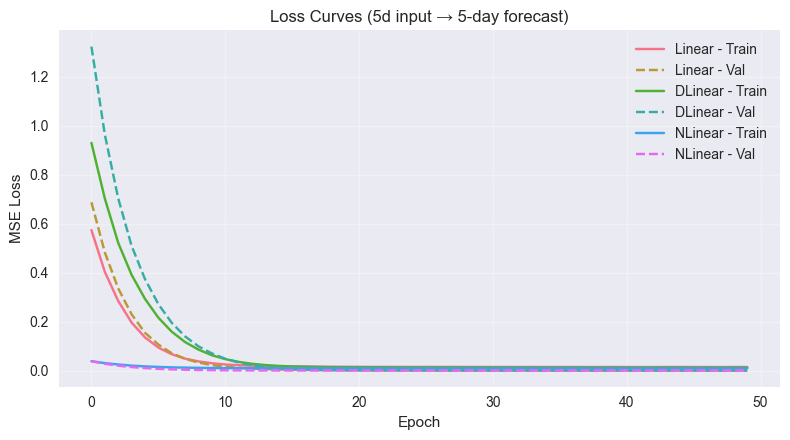

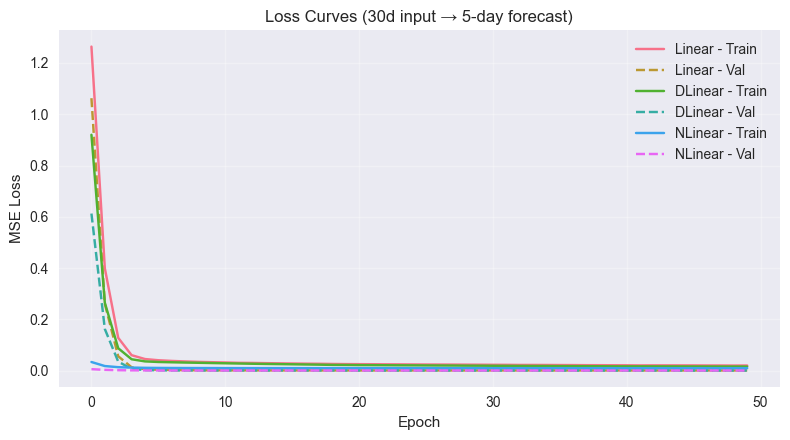

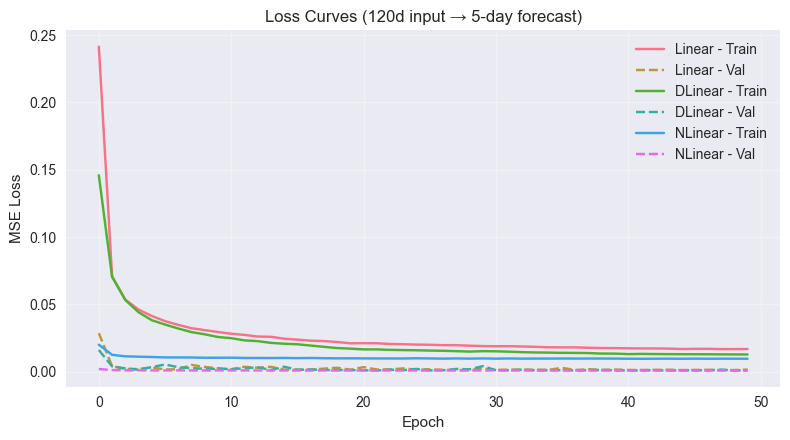

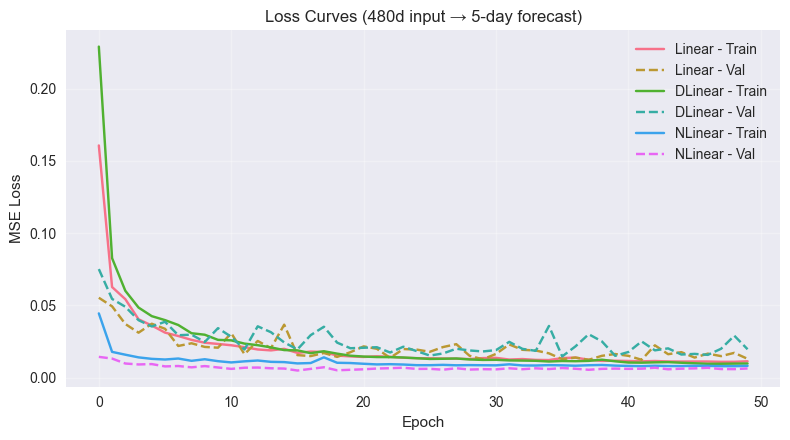

In [30]:
def plot_loss_curves(loss_history, horizons):
    for hz in horizons:
        plt.figure(figsize=(8, 4.5))
        for model_name in ["Linear", "DLinear", "NLinear"]:
            if hz in loss_history.get(model_name, {}):
                tl = loss_history[model_name][hz]["train"]
                vl = loss_history[model_name][hz]["val"]
                plt.plot(tl, label=f"{model_name} - Train")
                plt.plot(vl, linestyle="--", label=f"{model_name} - Val")
        plt.title(f"Loss Curves ({hz} input → 5-day forecast)")
        plt.xlabel("Epoch")
        plt.ylabel("MSE Loss")
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.show()


batch_size = 32
num_epochs = 50
learning_rate = 0.001

results = {"Linear": {}, "DLinear": {}, "NLinear": {}}
trained_models = {"Linear": {}, "DLinear": {}, "NLinear": {}}
loss_history = {"Linear": {}, "DLinear": {}, "NLinear": {}}

for horizon in ["5d", "30d", "120d", "480d"]:
    train_loader = DataLoader(
        normalized_data_splits[horizon]["train"],
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
    )
    val_loader = DataLoader(
        normalized_data_splits[horizon]["val"],
        batch_size=batch_size,
        shuffle=False,
        drop_last=True,
    )
    test_loader = DataLoader(
        normalized_data_splits[horizon]["test"],
        batch_size=batch_size,
        shuffle=False,
        drop_last=True,
    )

    for model_name in ["Linear", "DLinear", "NLinear"]:
        model = model_configs[model_name][horizon]["model"]
        trained_model, tr_losses, va_losses = train_model(
            model,
            train_loader,
            val_loader,
            num_epochs=num_epochs,
            lr=learning_rate,
            device=device,
        )
        loss_history[model_name][horizon] = {"train": tr_losses, "val": va_losses}
        trained_models[model_name][horizon] = trained_model

        # Optional: keep test metrics internally (no prints)
        test_results = evaluate_model_normalized(
            trained_model, test_loader, scaler, device
        )
        results[model_name][horizon] = test_results

# Visualize only
plot_loss_curves(loss_history, horizons=["5d", "30d", "120d", "480d"])


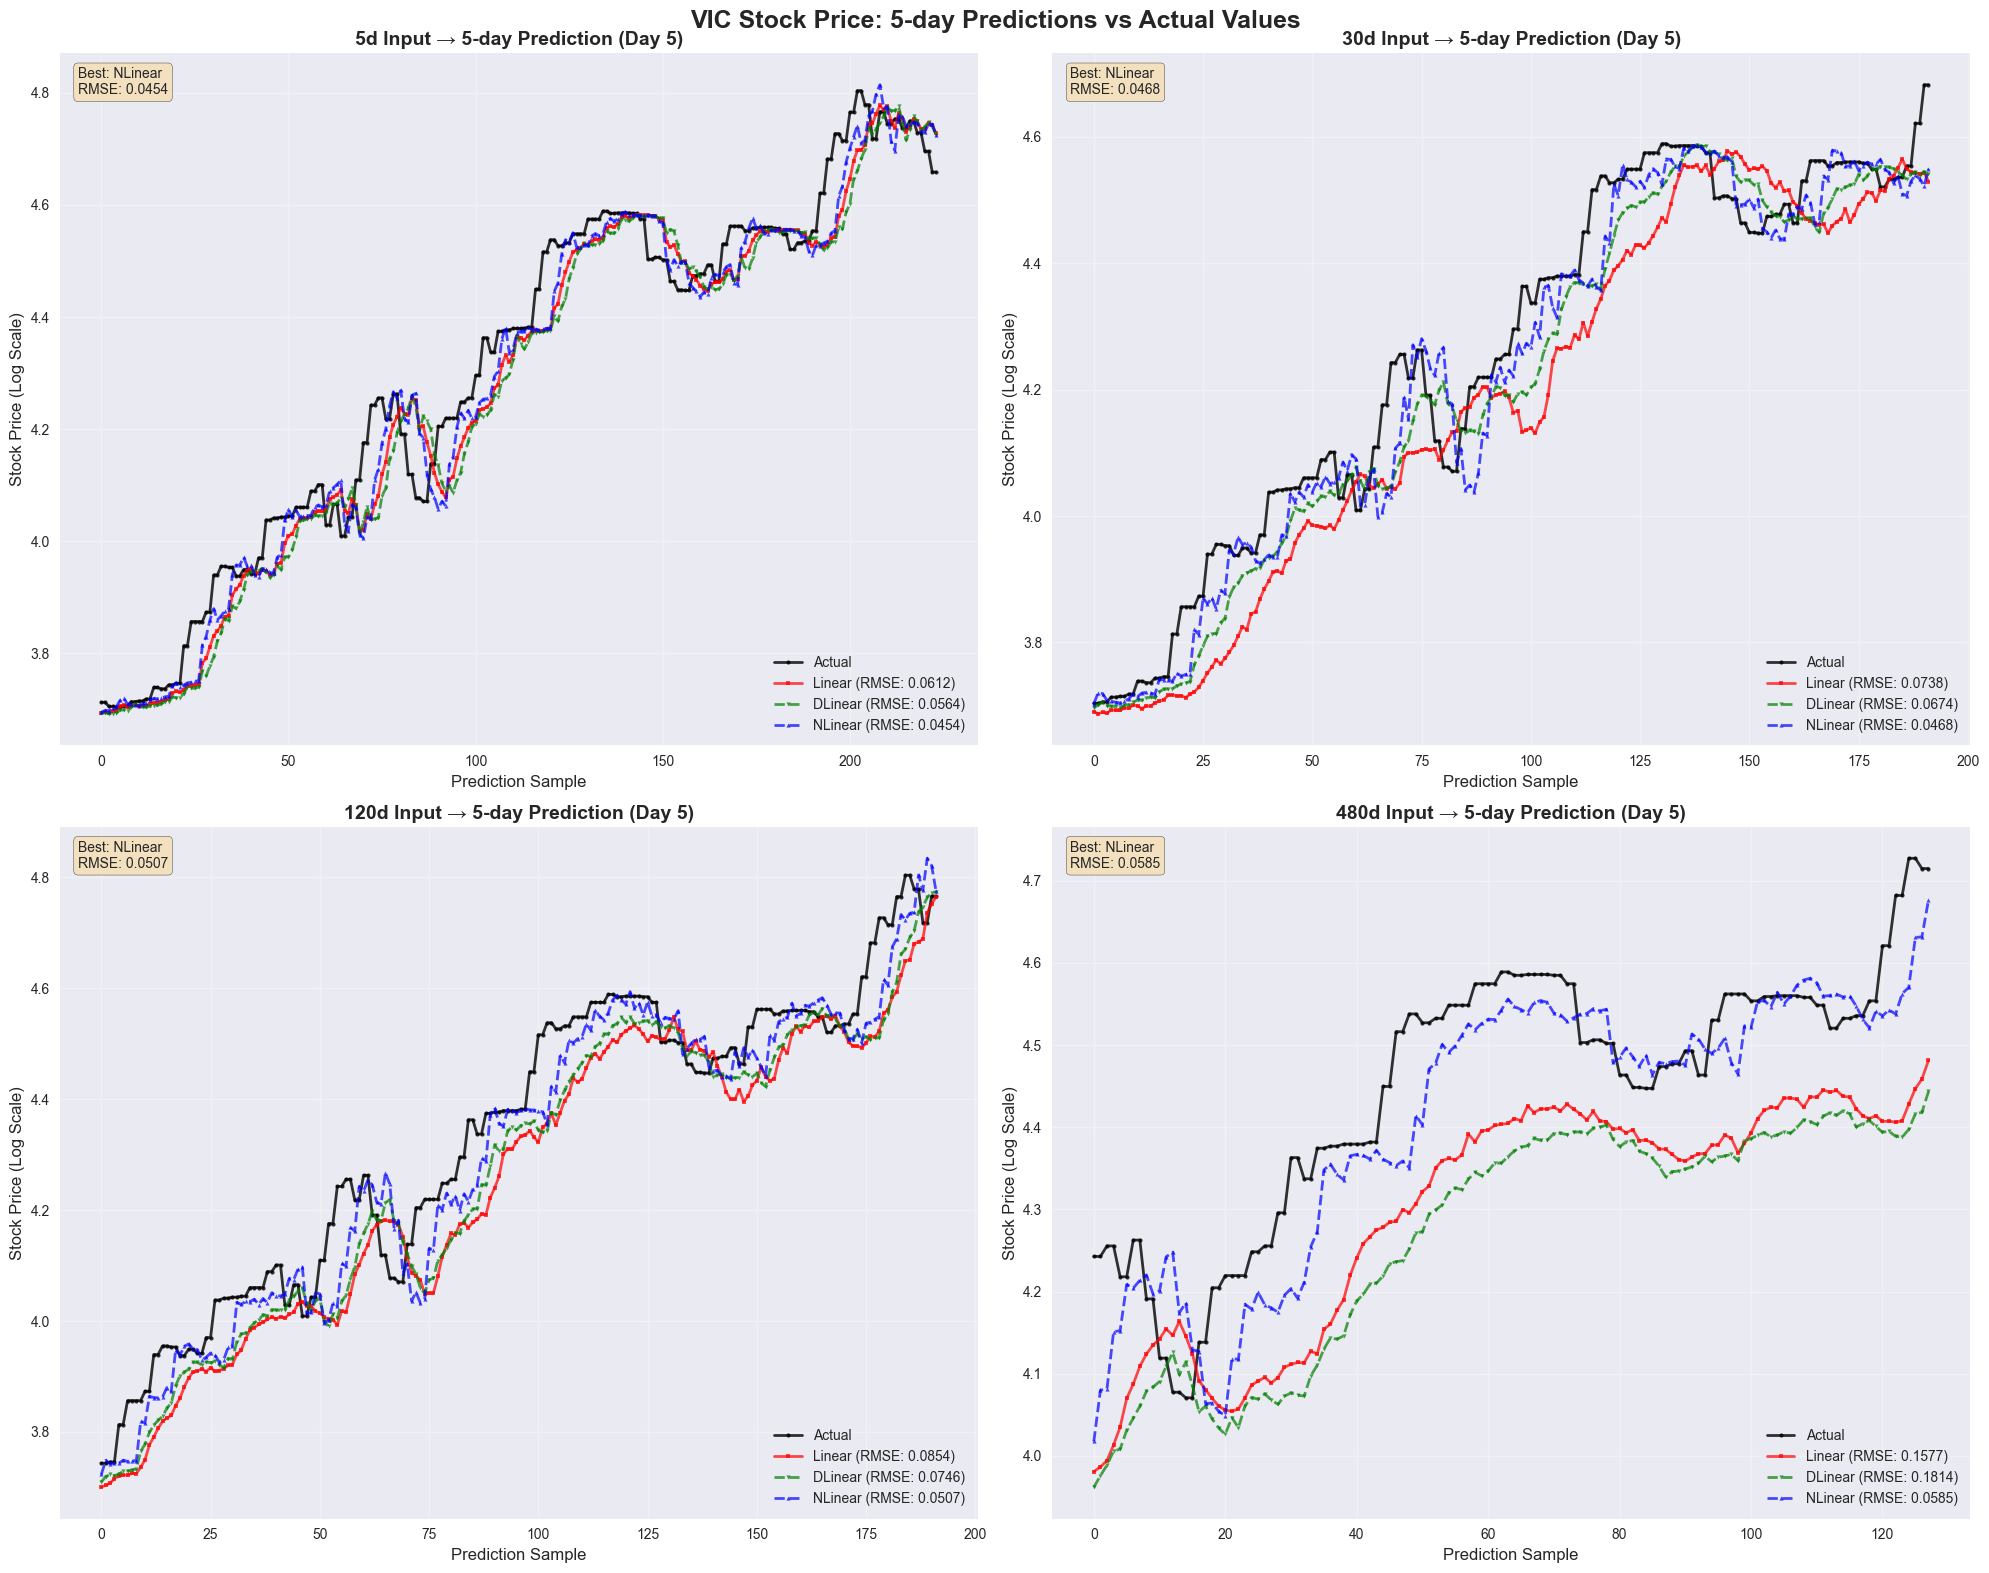

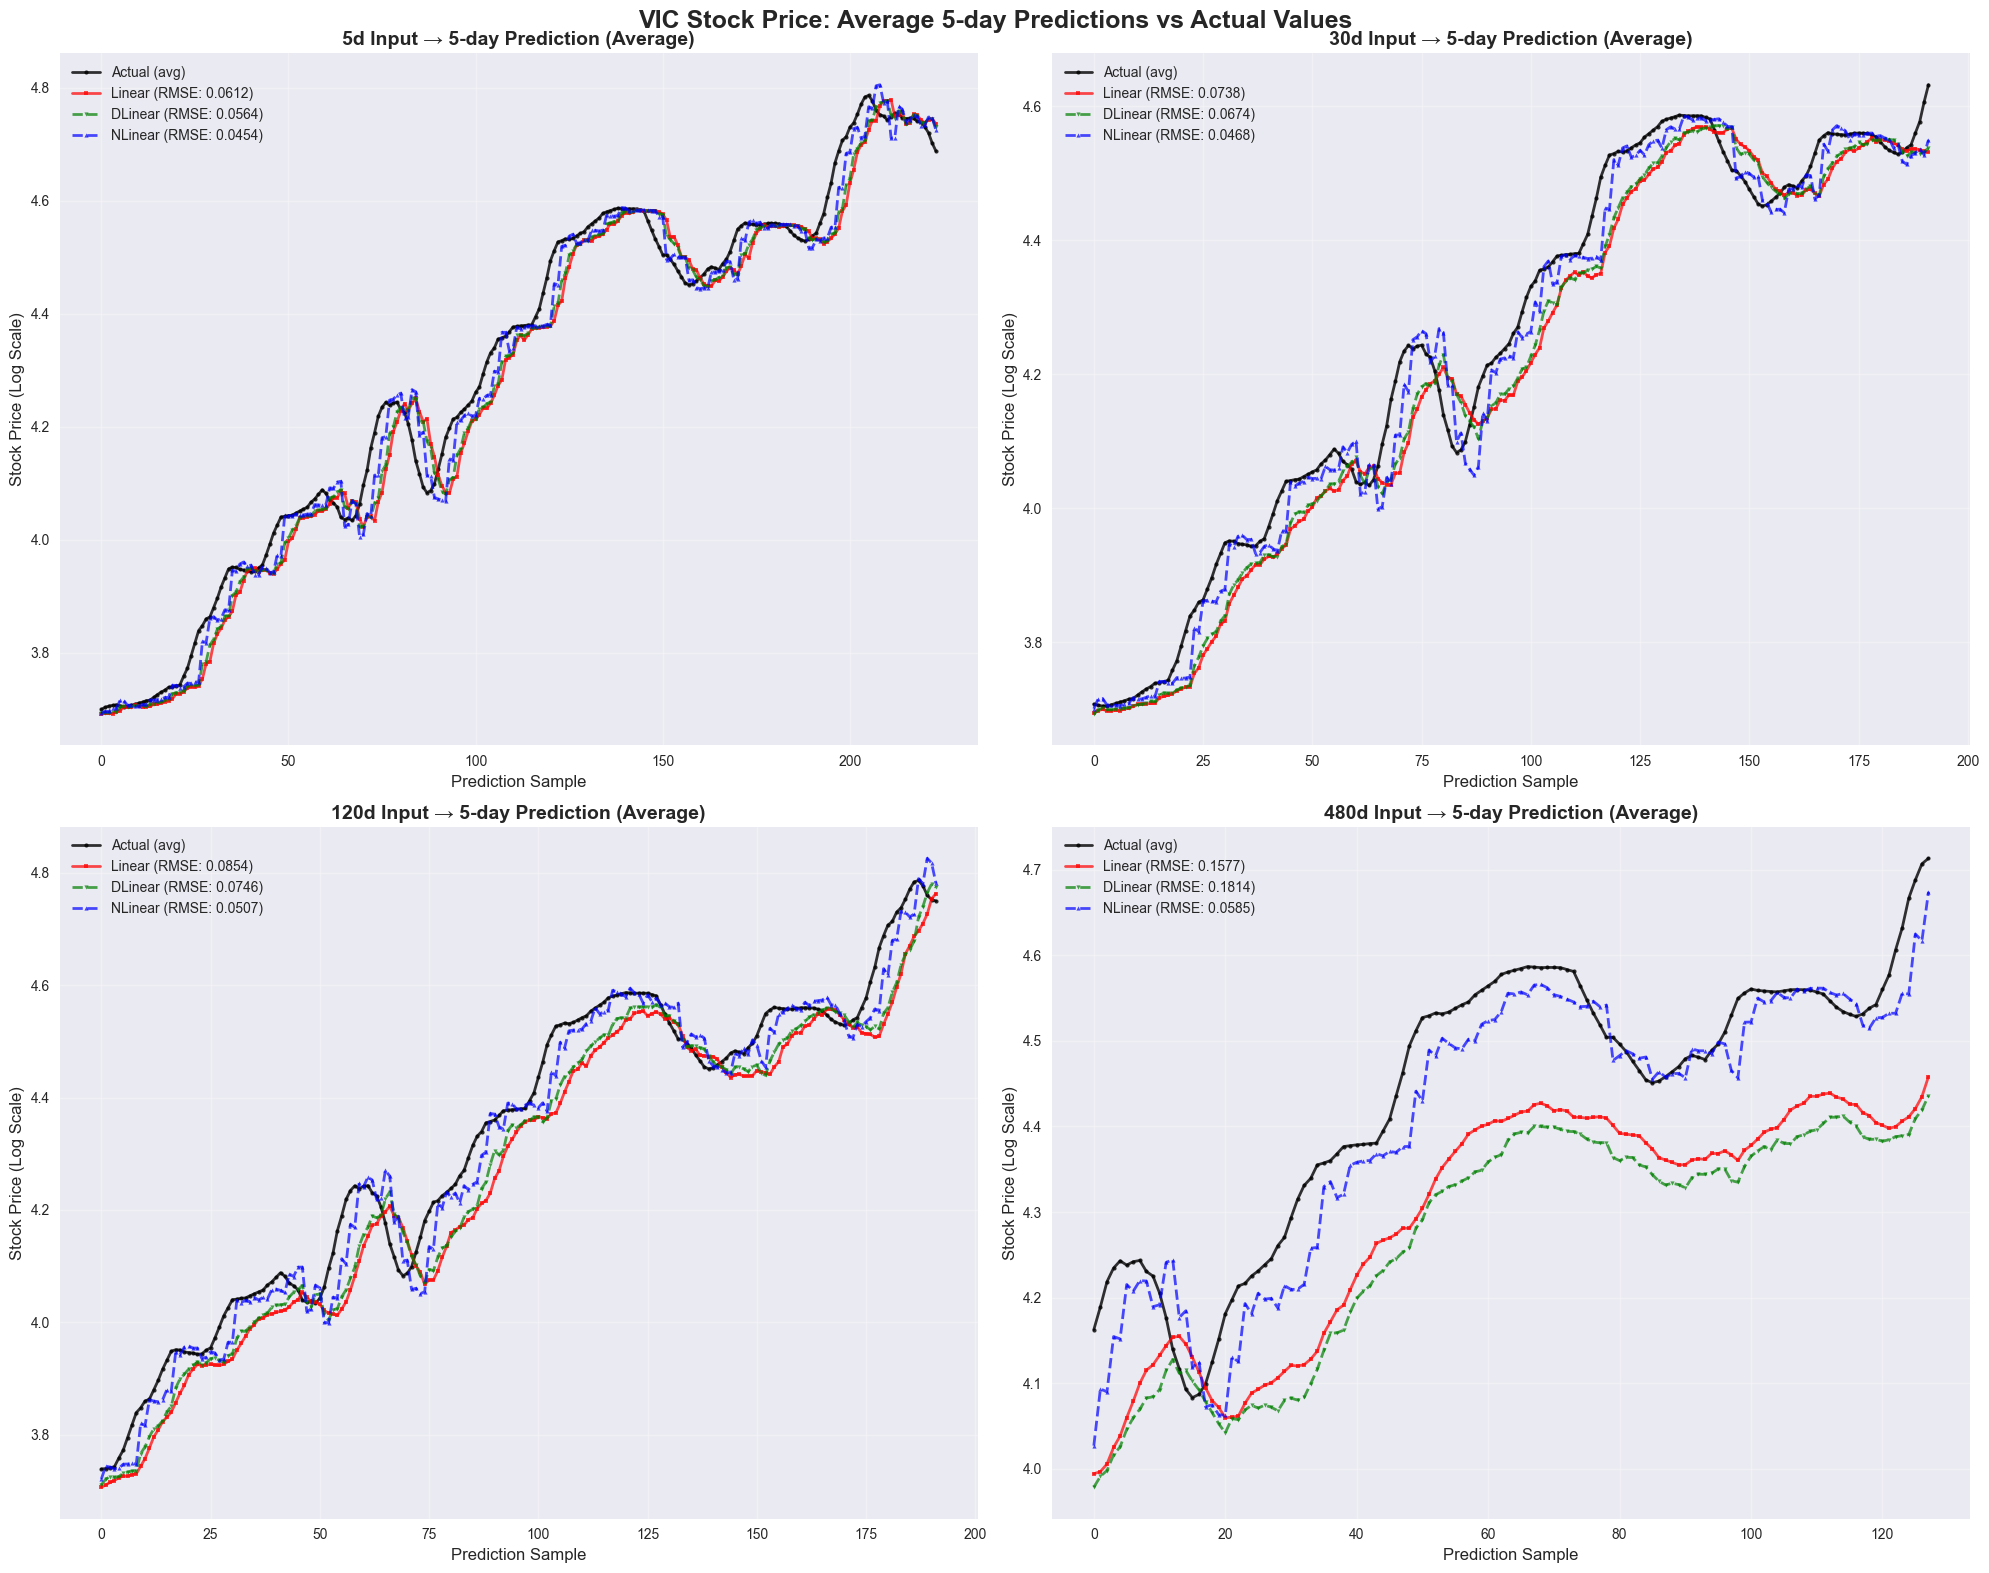


PERFORMANCE SUMMARY TABLE
Input Length   Model   RMSE    MAE      R²
          5d  Linear 0.0612 0.0448  0.9641
          5d DLinear 0.0564 0.0397  0.9696
          5d NLinear 0.0454 0.0298  0.9803
         30d  Linear 0.0738 0.0557  0.9348
         30d DLinear 0.0674 0.0501  0.9456
         30d NLinear 0.0468 0.0305  0.9738
        120d  Linear 0.0854 0.0692  0.9031
        120d DLinear 0.0746 0.0594  0.9261
        120d NLinear 0.0507 0.0350  0.9658
        480d  Linear 0.1577 0.1470  0.0063
        480d DLinear 0.1814 0.1704 -0.3142
        480d NLinear 0.0585 0.0438  0.8633


In [31]:
# Visualization of 5-day Prediction Results - Fixed for Flattened Data
# Create 4 subplots for 4 input lengths
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
fig.suptitle(
    "VIC Stock Price: 5-day Predictions vs Actual Values",
    fontsize=18,
    fontweight="bold",
)

horizons = ["5d", "30d", "120d", "480d"]
model_names = ["Linear", "DLinear", "NLinear"]
colors = {"Linear": "red", "DLinear": "green", "NLinear": "blue"}

for i, horizon in enumerate(horizons):
    ax = axes[i // 2, i % 2]

    # Get actual values (already flattened)
    actual_flat = results["Linear"][horizon]["actuals"]

    # Since data is flattened, we need to reshape it back to sequences
    # Each prediction contains 5 values, so we reshape accordingly
    pred_len = 5
    n_samples = len(actual_flat) // pred_len

    # Reshape to (n_samples, pred_len) và lấy giá trị ngày thứ 5
    actual_reshaped = actual_flat[: n_samples * pred_len].reshape(n_samples, pred_len)
    actual_values = actual_reshaped[:, -1]  # Take last day of each sequence

    # Plot actual values
    ax.plot(
        actual_values,
        "black",
        linewidth=2,
        label="Actual",
        alpha=0.8,
        marker="o",
        markersize=3,
    )

    # Plot predictions for each model
    for model_name in model_names:
        predictions_flat = results[model_name][horizon]["predictions"]
        rmse = results[model_name][horizon]["rmse"]

        # Reshape predictions and take last day
        pred_reshaped = predictions_flat[: n_samples * pred_len].reshape(
            n_samples, pred_len
        )
        predictions = pred_reshaped[:, -1]  # Take last day of each sequence

        ax.plot(
            predictions,
            color=colors[model_name],
            linewidth=2,
            label=f"{model_name} (RMSE: {rmse:.4f})",
            alpha=0.7,
            linestyle="--" if model_name != "Linear" else "-",
            marker="s"
            if model_name == "Linear"
            else ("v" if model_name == "DLinear" else "^"),
            markersize=3,
        )

    # Formatting
    ax.set_title(
        f"{horizon} Input → 5-day Prediction (Day 5)", fontsize=14, fontweight="bold"
    )
    ax.set_xlabel("Prediction Sample", fontsize=12)
    ax.set_ylabel("Stock Price (Log Scale)", fontsize=12)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)

    # Add performance summary text
    best_model = min(model_names, key=lambda m: results[m][horizon]["rmse"])
    best_rmse = results[best_model][horizon]["rmse"]
    ax.text(
        0.02,
        0.98,
        f"Best: {best_model}\nRMSE: {best_rmse:.4f}",
        transform=ax.transAxes,
        fontsize=10,
        verticalalignment="top",
        bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.8),
    )

plt.tight_layout()
plt.show()

# Alternative view: Show average prediction performance
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
fig.suptitle(
    "VIC Stock Price: Average 5-day Predictions vs Actual Values",
    fontsize=18,
    fontweight="bold",
)

for i, horizon in enumerate(horizons):
    ax = axes[i // 2, i % 2]

    # Get actual values and take average of each 5-day sequence
    actual_flat = results["Linear"][horizon]["actuals"]
    n_samples = len(actual_flat) // pred_len
    actual_reshaped = actual_flat[: n_samples * pred_len].reshape(n_samples, pred_len)
    actual_values = np.mean(actual_reshaped, axis=1)  # Take average of each sequence

    # Plot actual values
    ax.plot(
        actual_values,
        "black",
        linewidth=2,
        label="Actual (avg)",
        alpha=0.8,
        marker="o",
        markersize=3,
    )

    # Plot predictions for each model
    for model_name in model_names:
        predictions_flat = results[model_name][horizon]["predictions"]
        rmse = results[model_name][horizon]["rmse"]

        # Reshape and take average
        pred_reshaped = predictions_flat[: n_samples * pred_len].reshape(
            n_samples, pred_len
        )
        predictions = np.mean(pred_reshaped, axis=1)  # Take average of each sequence

        ax.plot(
            predictions,
            color=colors[model_name],
            linewidth=2,
            label=f"{model_name} (RMSE: {rmse:.4f})",
            alpha=0.7,
            linestyle="--" if model_name != "Linear" else "-",
            marker="s"
            if model_name == "Linear"
            else ("v" if model_name == "DLinear" else "^"),
            markersize=3,
        )

    # Formatting
    ax.set_title(
        f"{horizon} Input → 5-day Prediction (Average)", fontsize=14, fontweight="bold"
    )
    ax.set_xlabel("Prediction Sample", fontsize=12)
    ax.set_ylabel("Stock Price (Log Scale)", fontsize=12)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics table
print("\n" + "=" * 80)
print("PERFORMANCE SUMMARY TABLE")
print("=" * 80)

summary_data = []
for horizon in horizons:
    for model_name in model_names:
        result = results[model_name][horizon]
        summary_data.append(
            {
                "Input Length": horizon,
                "Model": model_name,
                "RMSE": f"{result['rmse']:.4f}",
                "MAE": f"{result['mae']:.4f}",
                "R²": f"{result['r2']:.4f}",
            }
        )

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))